# Homework: Learning Audio Representations with Self-Supervision

In this homework, we will consolidate the knowledge gained during the seminar and further explore methods for self-supervised learning of audio representations.
During the seminar, we implemented and trained a model based on contrastive learning (InfoNCE). Now, we will extend this work by implementing non-contrastive learning (NCL) approaches and comparing them with previously studied methods.

We will examine how different training paradigms — supervised, contrastive, and non-contrastive — affect the quality of learned embeddings and the stability of the training process

## Multi-Format Contrastive Learning of Audio Representations(Paper from seminar)

The core idea of this approach is to learn robust audio embeddings by contrasting
different *formats* (or views) of the same audio sample.  
For example, one branch may encode the **raw waveform (1D)** while another encodes
its **spectrogram (2D)**.  

By applying a contrastive loss (InfoNCE), the model is trained to:
- **Pull together** embeddings from different formats of the same audio,
- **Push apart** embeddings from different audio samples.  

This multi-format setup encourages the encoder to capture **shared semantic content**
across input representations, leading to more general and transferable audio features.

[paper1](https://arxiv.org/pdf/2103.06508), [paper2](https://arxiv.org/pdf/2010.09542)

[github source](https://github.com/HondamunigePrasannaSilva/CLAR?tab=readme-ov-file)

## AudioSet

Dataset with 10 numbers pronounced
```
!git clone https://github.com/soerenab/AudioMNIST.git
```


In [1]:
!git clone https://github.com/soerenab/AudioMNIST.git

fatal: destination path 'AudioMNIST' already exists and is not an empty directory.


код моделей, какие-то утилиты я положил в пакет (не сильный фанат ноутбуков если честно)

In [ ]:
!git clone https://github.com/imvladikon/deep_learning_school
!cp -r ./deep_learning_school/speech_recognition/hw3/audiossl .
!pip install uv
!cd audiossl && uv pip install -e . && cd ..

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm
from audiossl.data import collate_fn, LogMelSpectrogram, create_audiomnist_splits
from audiossl.modeling import (
    SupervisedAudioClassifier, 
    MultiFormatContrastiveModel, 
    SimSiamMultiFormat,
    ContrastiveWithLinearHead,
    NCLWithLinearHead,
)
from audiossl.losses import InfoNCELoss, SimSiamLoss
from audiossl.training import (
    train_epoch_supervised, validate_supervised,
    train_epoch_contrastive, validate_contrastive,
    train_epoch_simsiam, validate_simsiam,
    train_epoch_linear_head, validate_linear_head,
)
from audiossl.utils import (
    NotebookVisualizer,
    create_default_callbacks,
    WandbCallback,
    log_audio_predictions_supervised,
    log_audio_embeddings_ssl,
    listen_and_predict,
    listen_and_predict_ssl,
    listen_and_predict_head,
    log_audio_predictions_with_classifier
)
from audiossl.utils.callbacks import CallbackList, NotebookCallback

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
try:
    import wandb
    USE_WANDB = True
except:
    USE_WANDB = False

In [4]:
from pathlib import Path
DATA_ROOT = "./AudioMNIST/data"
DATA_ROOT = Path(DATA_ROOT).resolve()

if not DATA_ROOT.exists():
    !git clone https://github.com/soerenab/AudioMNIST.git

CHECKPOINT_DIR = Path("./checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)


(CHECKPOINT_DIR / "task_1").mkdir(parents=True, exist_ok=True)
(CHECKPOINT_DIR / "task_2").mkdir(parents=True, exist_ok=True)
(CHECKPOINT_DIR / "task_3").mkdir(parents=True, exist_ok=True)

EXP_DIR = Path("./experiments")
for subdir in ["supervised", "contrastive", "simsiam"]:
    (EXP_DIR / subdir).mkdir(parents=True, exist_ok=True)

In [5]:
config_supervised = {
    "encoder_type": "1d",  # "1d" | "2d" | "both"
    "batch_size": 32,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "num_epochs": 40,
    "num_classes": 10,
    "sample_rate": 16000,
    "hidden_dim": 256,
    "early_stop_patience": 5,
    "num_test_speakers": 12,
    "num_workers": 4,
}

In [7]:
print("Loading AudioMNIST dataset...")
train_dataset, val_dataset, full_dataset = create_audiomnist_splits(
    root=DATA_ROOT,
    num_test_speakers=config_supervised["num_test_speakers"]
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=config_supervised["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=config_supervised["num_workers"],
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config_supervised["batch_size"],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config_supervised["num_workers"],
    pin_memory=True,
)

spectrogram_transform = None
if config_supervised["encoder_type"] in ["2d", "both"]:
    spectrogram_transform = LogMelSpectrogram(
        sample_rate=config_supervised["sample_rate"],
        n_mels=64,
        n_fft=400,
        hop_length=160,
    )
    print("Created spectrogram transform")

model_supervised = SupervisedAudioClassifier(
    encoder_type=config_supervised["encoder_type"],
    num_classes=config_supervised["num_classes"],
    hidden_dim=config_supervised["hidden_dim"],
).to(device)

num_params = (
    sum(p.numel() for p in model_supervised.parameters() if p.requires_grad)
)
print(f"Model parameters: {num_params:,}")
model_supervised

Loading AudioMNIST dataset...
Train samples: 24000
Val samples: 6000
Model parameters: 2,933,578


SupervisedAudioClassifier(
  (encoder_1d): ResNet1D(
    (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Block1D(
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): Block1D(
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
 

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model_supervised.parameters(),
    lr=config_supervised["lr"],
    weight_decay=config_supervised["weight_decay"]
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=4
)

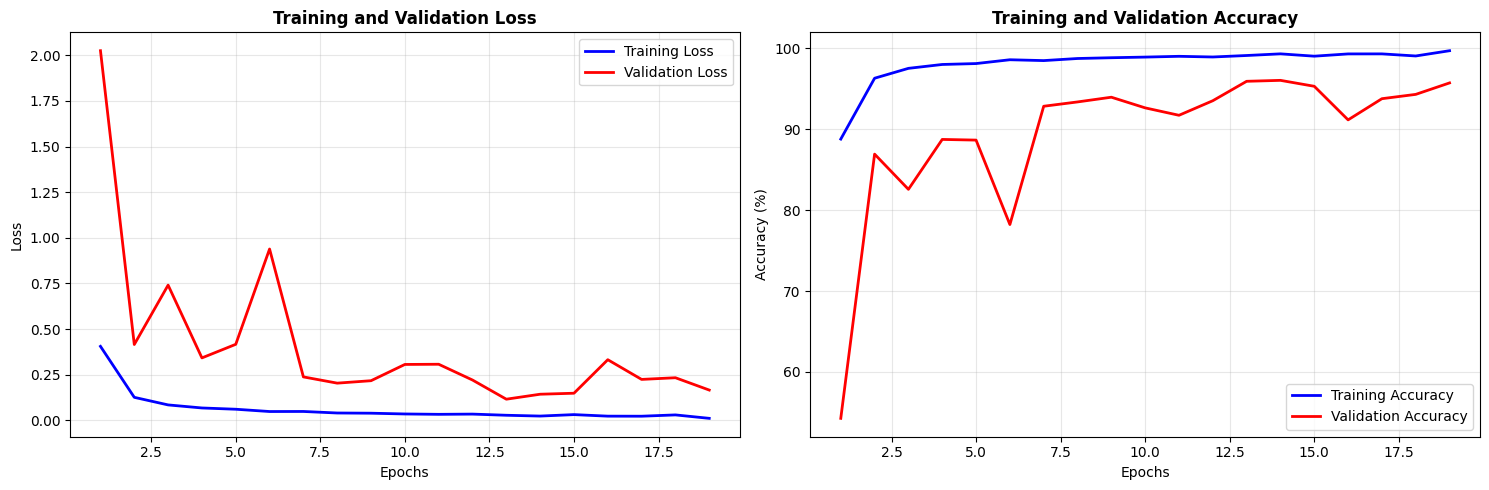


Epoch 19:
  Train Loss: 0.0111, Train Acc: 99.70%
  Val Loss:   0.1660, Val Acc:   95.72%
Early stopping at epoch 19

Training complete!
Best validation accuracy: 96.03% at epoch 14


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇██
learning_rate,█████████████████▁▁
train/accuracy,▁▆▇▇▇▇▇▇▇▇█████████
train/loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▆▆▇▇▅▇██▇▇████▇███
val/loss,█▂▃▂▂▄▁▁▁▂▂▁▁▁▁▂▁▁▁
best_epoch,14
best_val_accuracy,96.03333
epoch,19
learning_rate,0.00015
train/accuracy,99.69583


In [11]:
# I implemented callbacks : 
# 1. notebook allows printing metrics and plots (borrowed from the seminar notebook code)
# 2. wandb callback - logs metrics/losses along with the table of the incorrect predictions of some samples across each epoch
if USE_WANDB:
    wandb.init(
        project="audiomnist-ssl",
        name=f"supervised-{config_supervised['encoder_type']}",
        config=config_supervised,
        tags=["supervised", "audiomnist"],
    )
    print(f"WandB: {wandb.run.url}\n")
    
callbacks = create_default_callbacks(use_wandb=USE_WANDB, use_notebook=True)
viz_supervised = callbacks["notebook"].visualizer

best_val_acc = 0
best_epoch = 0
epochs_without_improvement = 0

print(f"Training supervised model for {config_supervised['num_epochs']} epochs...")

callbacks.on_train_begin({"config": config_supervised})

for epoch in range(1, config_supervised["num_epochs"] + 1):
    callbacks.on_epoch_begin(epoch)

    train_loss, train_acc = train_epoch_supervised(
        model_supervised, train_loader, criterion, optimizer, device, spectrogram_transform
    )
    val_loss, val_acc = validate_supervised(
        model_supervised, val_loader, criterion, device, spectrogram_transform
    )

    scheduler.step(val_loss)

    epoch_logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr'],
    }
    callbacks.on_epoch_end(epoch, epoch_logs)

    if USE_WANDB and epoch % 5 == 0:
        log_audio_predictions_supervised(
            model=model_supervised,
            dataloader=val_loader,
            device=device,
            spectrogram_transform=spectrogram_transform,
            num_samples=10,
            epoch=epoch,
            sample_rate=config_supervised["sample_rate"],
        )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        epochs_without_improvement = 0
        print(f"New best! Val Acc: {val_acc:.2f}%")
        
        checkpoint_path = CHECKPOINT_DIR / "task_1" / "supervised_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_supervised.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': config_supervised,
        }, checkpoint_path)
        print(f"  Saved checkpoint: {checkpoint_path}")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= config_supervised["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\nTraining complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")

callbacks.on_train_end({
    "best_val_acc": best_val_acc,
    "best_epoch": best_epoch,
})

if USE_WANDB:
    wandb.finish()

possible get even better results here (with some proper hyperparameters, patience , more num epochs),  because when I trained it in cli I got around 98-99% on validation

In [12]:
history_supervised = viz_supervised.get_history()
print("\nTask 1 Results (Supervised Learning):")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Best epoch: {best_epoch}")
print(f"  Final train accuracy: {history_supervised['train_acc'][-1]:.2f}%")
print(f"  Final val accuracy: {history_supervised['val_acc'][-1]:.2f}%")


Task 1 Results (Supervised Learning):
  Best validation accuracy: 96.03%
  Best epoch: 14
  Final train accuracy: 99.70%
  Final val accuracy: 95.72%


In [13]:
import json

with open(EXP_DIR / "supervised" / "history.json", "w") as f:
    json.dump(history_supervised, f, indent=2)

with open(EXP_DIR / "supervised" / "config.json", "w") as f:
    json.dump(config_supervised, f, indent=2)

## Task 2(2 points)

Train the Multi-Format Contrastive Learning of Audio Representations model (implemented during the seminar) until convergence. Plot the loss and accuracy curves to verify that the training process has stabilized.

In [9]:
config_contrastive = {
    "batch_size": 32,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "num_epochs": 40,
    "sample_rate": 16000,
    "hidden_dim": 256,
    "proj_dim": 128,
    "temperature": 0.1, # 0.07 | 0.5
    "early_stop_patience": 15,
    "num_test_speakers": 12,
    "num_workers": 4,
    "norm_type": "batch", # batch | layer
}

In [20]:
train_loader_contrast = DataLoader(
    train_dataset,
    batch_size=config_contrastive["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=config_contrastive["num_workers"],
    pin_memory=True,
    persistent_workers=True,          
    multiprocessing_context="spawn",  
)

val_loader_contrast = DataLoader(
    val_dataset,
    batch_size=config_contrastive["batch_size"],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config_contrastive["num_workers"],
    pin_memory=True,
    persistent_workers=True,         
    multiprocessing_context="spawn",  
)

spec_transform_contrast = LogMelSpectrogram(
    sample_rate=config_contrastive["sample_rate"],
    n_mels=64,
    n_fft=400,
    hop_length=160,
)

from audiossl.data import ContrastiveAudioAugmentation

augment_contrast = ContrastiveAudioAugmentation(
    sample_rate=config_contrastive["sample_rate"],
    p=0.5
)

model_contrastive = MultiFormatContrastiveModel(
    projector_hidden_dim=config_contrastive["hidden_dim"],
    projector_output_dim=config_contrastive["proj_dim"],
    norm_type = config_contrastive["norm_type"]
).to(device)

num_params_contrast = sum(p.numel() for p in model_contrastive.parameters() if p.requires_grad)
print(f"Contrastive model parameters: {num_params_contrast:,}")

criterion_contrast = InfoNCELoss(temperature=config_contrastive["temperature"])
optimizer_contrast = optim.Adam(
    model_contrastive.parameters(),
    lr=config_contrastive["lr"],
    weight_decay=config_contrastive["weight_decay"]
)

scheduler_contrast = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_contrast,
    mode="min",
    factor=0.5,
    patience=5
)
# scheduler_contrast = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)


if (CHECKPOINT_DIR / "contrastive_ssl_best.pth").exists():
    checkpoint = torch.load(CHECKPOINT_DIR / "contrastive_ssl_best.pth")
    
    model_contrastive = MultiFormatContrastiveModel(
        projector_hidden_dim=config_contrastive["hidden_dim"],
        projector_output_dim=config_contrastive["proj_dim"],
    )
    
    model_contrastive.load_state_dict(checkpoint['model_state_dict'])
    model_contrastive.to(device)

model_contrastive

Contrastive model parameters: 10,009,984


MultiFormatContrastiveModel(
  (encoder_1d): ResNet1D(
    (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Block1D(
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): Block1D(
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))

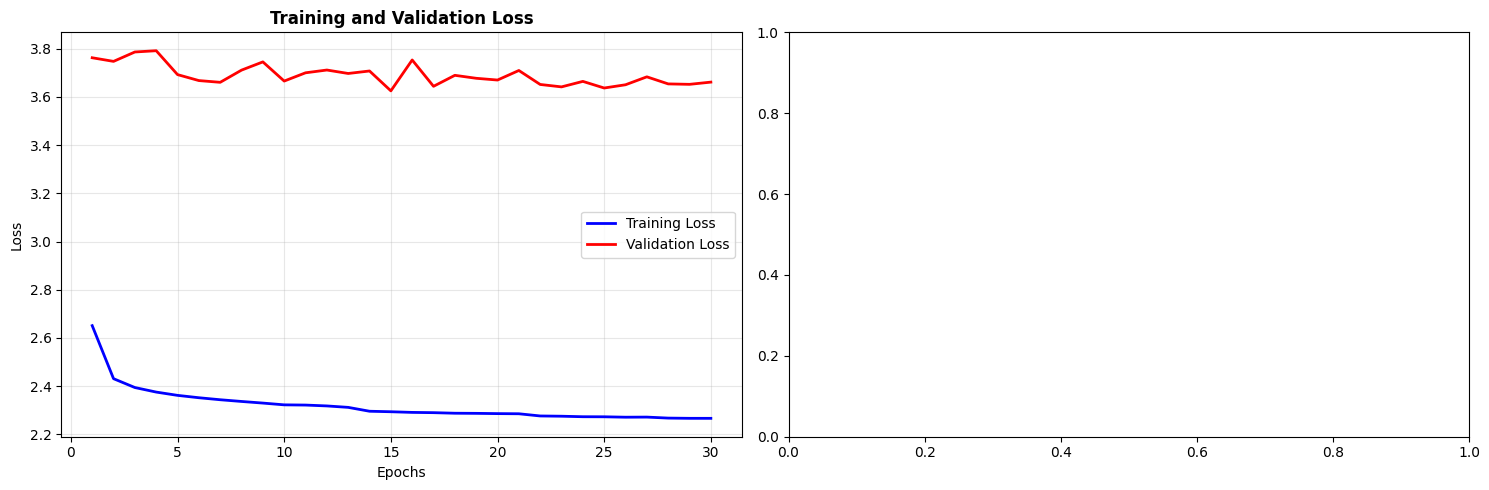


Epoch 30:
  Train Loss: 2.2661
  Val Loss:   3.6617
Early stopping at epoch 30

Contrastive training complete!
Best validation loss: 3.6254 at epoch 15


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning_rate,████████████▄▄▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁
train/loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,▇▆██▄▃▂▅▆▃▄▅▄▄▁▆▂▄▃▃▅▂▂▃▁▂▃▂▂▃
best_epoch,15
epoch,30
learning_rate,4e-05
train/loss,2.26608
val/loss,3.66169


In [16]:
callbacks_contrast = create_default_callbacks(use_wandb=USE_WANDB, use_notebook=True)
viz_contrastive = callbacks_contrast["notebook"].visualizer

best_val_loss_contrast = float('inf')
best_epoch_contrast = 0
epochs_without_improvement_contrast = 0

print(f"Training contrastive model for {config_contrastive['num_epochs']} epochs...")
callbacks_contrast.on_train_begin({"config": config_contrastive})

for epoch in range(1, config_contrastive["num_epochs"] + 1):
    callbacks_contrast.on_epoch_begin(epoch)

    train_loss = train_epoch_contrastive(
        model_contrastive, train_loader_contrast, criterion_contrast,
        optimizer_contrast, device, spec_transform_contrast,
        augment_fn=augment_contrast
    )
    val_loss = validate_contrastive(
        model_contrastive, val_loader_contrast, criterion_contrast,
        device, spec_transform_contrast
    )

    scheduler_contrast.step(val_loss)

    epoch_logs = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "learning_rate": optimizer_contrast.param_groups[0]['lr'],
    }
    callbacks_contrast.on_epoch_end(epoch, epoch_logs)

    if USE_WANDB and epoch % 5 == 0:
        log_audio_embeddings_ssl(
            model=model_contrastive,
            dataloader=val_loader_contrast,
            device=device,
            spectrogram_transform=spec_transform_contrast,
            num_samples=10,
            epoch=epoch,
            sample_rate=config_contrastive["sample_rate"],
            view="1d",  # "1d" | "2d" | "both"
        )

    if val_loss < best_val_loss_contrast:
        best_val_loss_contrast = val_loss
        best_epoch_contrast = epoch
        epochs_without_improvement_contrast = 0
        print(f"New best! Val Loss: {val_loss:.4f}")
        
        # Save best model checkpoint
        checkpoint_path = CHECKPOINT_DIR / "contrastive_ssl_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_contrastive.state_dict(),
            'optimizer_state_dict': optimizer_contrast.state_dict(),
            'val_loss': val_loss,
            'config': config_contrastive,
        }, checkpoint_path)
        print(f"  Saved checkpoint: {checkpoint_path}")
    else:
        epochs_without_improvement_contrast += 1

    if epochs_without_improvement_contrast >= config_contrastive["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\nContrastive training complete!")
print(f"Best validation loss: {best_val_loss_contrast:.4f} at epoch {best_epoch_contrast}")

callbacks_contrast.on_train_end({
    "best_val_loss": best_val_loss_contrast,
    "best_epoch": best_epoch_contrast,
})

if USE_WANDB:
    wandb.finish()

In [17]:
history_contrastive = viz_contrastive.get_history()
print("\nTask 2 Results (Contrastive Learning - InfoNCE):")
print(f"  Best validation loss: {best_val_loss_contrast:.4f}")
print(f"  Best epoch: {best_epoch_contrast}")
print(f"  Final train loss: {history_contrastive['train_loss'][-1]:.4f}")
print(f"  Final val loss: {history_contrastive['val_loss'][-1]:.4f}")
print("\n  Note: Loss convergence indicates stable training.")
print("  Lower loss suggests better alignment of multi-format embeddings.")


Task 2 Results (Contrastive Learning - InfoNCE):
  Best validation loss: 3.6254
  Best epoch: 15
  Final train loss: 2.2661
  Final val loss: 3.6617

  Note: Loss convergence indicates stable training.
  Lower loss suggests better alignment of multi-format embeddings.


In [18]:
import json

with open(EXP_DIR / "contrastive" / "history.json", "w") as f:
    json.dump(history_contrastive, f, indent=2)

with open(EXP_DIR / "contrastive" / "config.json", "w") as f:
    json.dump(config_contrastive, f, indent=2)

### task 2 (a) - freeze encoder

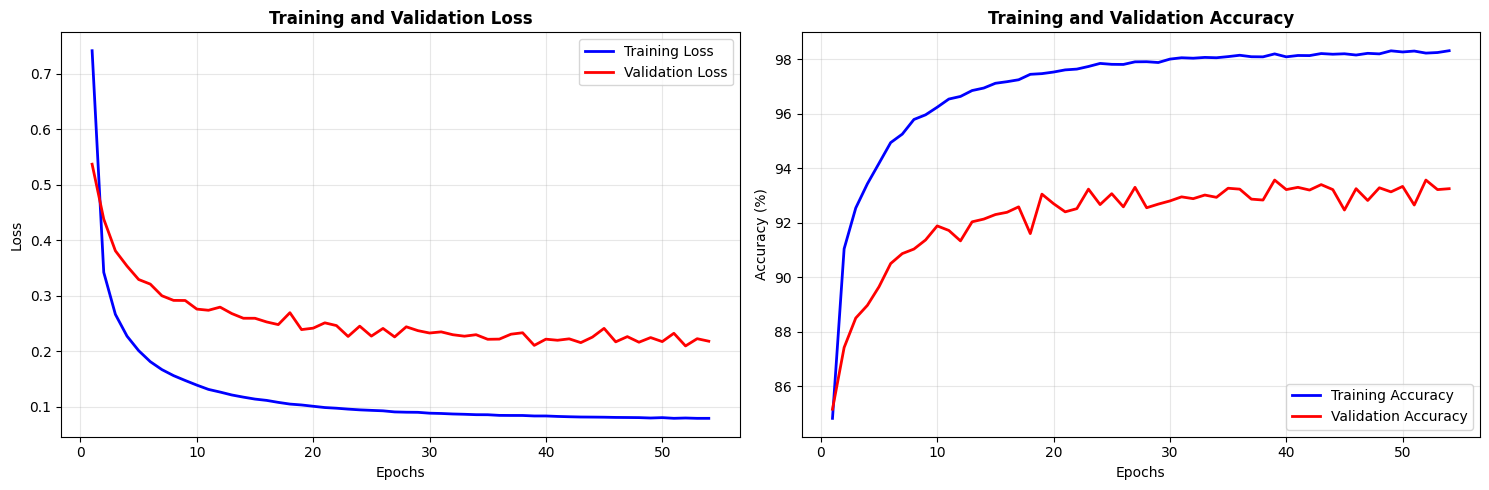


Epoch 54:
  Train Loss: 0.0794, Train Acc: 98.32%
  Val Loss:   0.2183, Val Acc:   93.25%
Early stopping at epoch 54

Linear Evaluation Complete!
Best Validation Accuracy: 93.57% at epoch 39



epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▄▅▅▆▇▇▇▇▇▇▇████████████████████████████
train/loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▃▄▄▅▇▆▇▇▇▆█▇▇▇▇█▇█▇▇▇▇▇█▇▇█████▇█▇██▇██
val/loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁
best_epoch,39
best_val_accuracy,93.56667
epoch,54
learning_rate,0.0003
train/accuracy,98.31667


In [11]:
from audiossl.modeling import ContrastiveWithLinearHead
from audiossl.training import train_epoch_linear_head, validate_linear_head


model_contrastive_linear = ContrastiveWithLinearHead(
    contrastive_model=model_contrastive,
    num_classes=10,
    freeze_encoder=True,
    input_dim=512,
).to(device)


callbacks = create_default_callbacks(use_wandb=USE_WANDB, use_notebook=True)
viz_supervised = callbacks["notebook"].visualizer

criterion_linear = nn.CrossEntropyLoss()
optimizer_linear = optim.Adam(
    model_contrastive_linear.classifier.parameters(), 
    lr=1e-3,
    weight_decay=1e-4,
)

config_linear_contrast = {
    "num_epochs": 100,
    "early_stop_patience": 15,
    "view": "2d", # 1d doesn't give a proper accuracy
    "sample_rate": 16_000
}

best_val_acc_linear_contrast = 0
best_epoch_linear_contrast = 0
epochs_without_improvement = 0

print(f"Training linear classifier on {config_linear_contrast['view']} encoder features...")

callbacks.on_train_begin({"config": config_linear_contrast})

for epoch in range(1, config_linear_contrast["num_epochs"] + 1):
    callbacks.on_epoch_begin(epoch)
    
    train_loss, train_acc = train_epoch_linear_head(
        model_contrastive_linear,
        train_loader_contrast,
        criterion_linear,
        optimizer_linear,
        device,
        spec_transform_contrast,
        view=config_linear_contrast["view"],
    )
    
    val_loss, val_acc = validate_linear_head(
        model_contrastive_linear,
        val_loader_contrast,
        criterion_linear,
        device,
        spec_transform_contrast,
        view=config_linear_contrast["view"],
    )
    
    print(f"Epoch {epoch}/{config_linear_contrast['num_epochs']}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    
    epoch_logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr'],
    }

    callbacks.on_epoch_end(epoch, epoch_logs)

    if USE_WANDB and epoch % 5 == 0:
        log_audio_predictions_with_classifier(
            model=model_contrastive,
            classifier=model_contrastive_linear,
            dataloader=val_loader_contrast,
            device=device,
            spectrogram_transform=spec_transform_contrast,
            num_samples=10,
            epoch=epoch,
            sample_rate=config_linear_contrast["sample_rate"],
            view=config_linear_contrast["view"],
        )
  
    
    if val_acc > best_val_acc_linear_contrast:
        best_val_acc_linear_contrast = val_acc
        best_epoch_linear_contrast = epoch
        epochs_without_improvement = 0
        print(f"  New best! Val Acc: {val_acc:.2f}%")
        
        checkpoint_path = CHECKPOINT_DIR / "contrastive_linear_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_contrastive_linear.state_dict(),
            'optimizer_state_dict': optimizer_linear.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': config_linear_contrast,
        }, checkpoint_path)
        print(f"  Saved checkpoint: {checkpoint_path}")
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= config_linear_contrast["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\n{'='*80}")
print(f"Linear Evaluation Complete!")
print(f"Best Validation Accuracy: {best_val_acc_linear_contrast:.2f}% at epoch {best_epoch_linear_contrast}")
print(f"{'='*80}\n")



callbacks.on_train_end({
    "best_val_acc": best_val_acc_linear_contrast,
    "best_epoch": best_epoch_linear_contrast,
})

if USE_WANDB:
    wandb.finish()

In [15]:
history_linear_contrast = viz_supervised.get_history()
print("\nTask 1 Results (Supervised Learning):")
print(f"  Final train accuracy: {history_linear_contrast['train_acc'][-1]:.2f}%")
print(f"  Final val accuracy: {history_linear_contrast['val_acc'][-1]:.2f}%")


Task 1 Results (Supervised Learning):
  Final train accuracy: 98.32%
  Final val accuracy: 93.25%


In [16]:
import json

with open(EXP_DIR / "contrastive" / "head_history.json", "w") as f:
    json.dump(history_linear_contrast, f, indent=2)

with open(EXP_DIR / "contrastive" / "head_config.json", "w") as f:
    json.dump(config_linear_contrast, f, indent=2)

### task 2 (b) - unfreeze encoder
!requires re-run cell with model init and dataloader init     
note: maybe better is to make just a joint model and I implemented joint model with train_joint_contrastive.py script, but didn't have time to run it yet

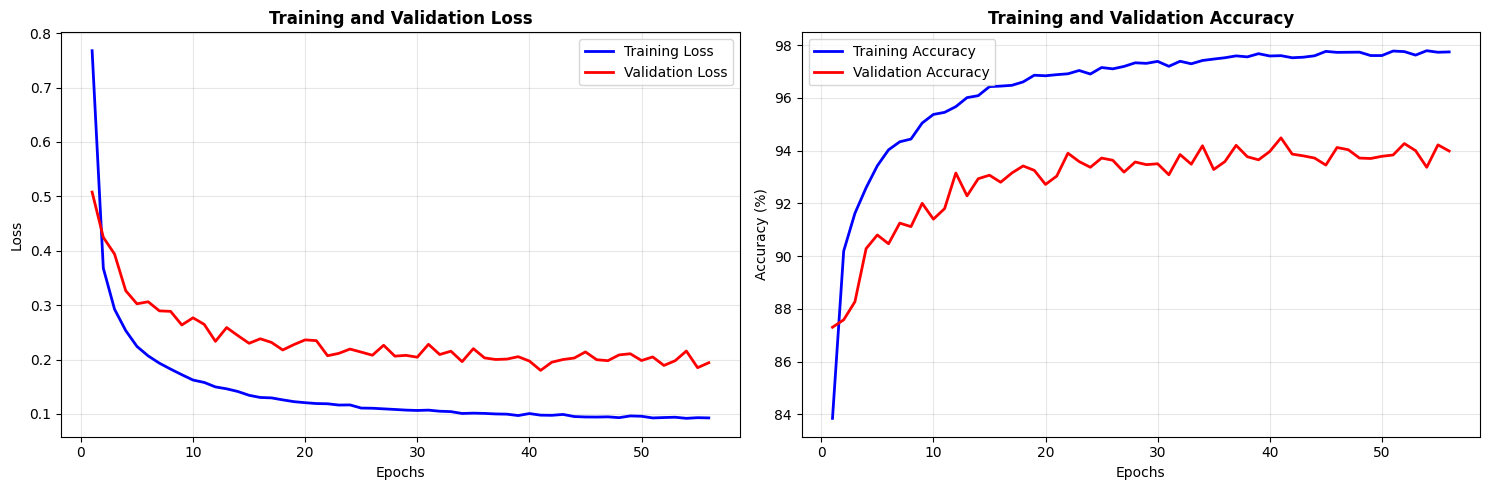


Epoch 56:
  Train Loss: 0.0927, Train Acc: 97.74%
  Val Loss:   0.1942, Val Acc:   93.98%
Early stopping at epoch 56

Linear Evaluation Complete!
Best Validation Accuracy: 94.48% at epoch 41



epoch,▁▁▂▁▁▂▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▄▅▅▆▅▁▄▅▅▆▆▆▇▇▇▇███████████████████████
train/loss,█▃▃▂█▃▂█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▃▄▅▂▄▅▂▂▃▅▅▅▆▆▆▇▇▇▇▇▇█▇█▇▇█▇███████████
val/loss,█▆▄▄▅█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▂▂▁▂▁
best_epoch,41
best_val_accuracy,94.48333
epoch,56
learning_rate,0.0003
train/accuracy,97.74167


In [21]:
from audiossl.modeling import ContrastiveWithLinearHead
from audiossl.training import train_epoch_linear_head, validate_linear_head


model_contrastive_linear = ContrastiveWithLinearHead(
    contrastive_model=model_contrastive,
    num_classes=10,
    freeze_encoder=False,
    input_dim=512,
).to(device)


callbacks = create_default_callbacks(use_wandb=USE_WANDB, use_notebook=True)
viz_supervised = callbacks["notebook"].visualizer

criterion_linear = nn.CrossEntropyLoss()
optimizer_linear = optim.Adam(
    model_contrastive_linear.classifier.parameters(), 
    lr=1e-3,
    weight_decay=1e-4,
)

config_linear_contrast = {
    "num_epochs": 100,
    "early_stop_patience": 15,
    "view": "2d", # 1d doesn't give a proper accuracy
    "sample_rate": 16_000,
}

best_val_acc_linear_contrast = 0
best_epoch_linear_contrast = 0
epochs_without_improvement = 0

print(f"Training linear classifier on {config_linear_contrast['view']} encoder features...")

callbacks.on_train_begin({"config": config_linear_contrast})

for epoch in range(1, config_linear_contrast["num_epochs"] + 1):
    callbacks.on_epoch_begin(epoch)
    
    train_loss, train_acc = train_epoch_linear_head(
        model_contrastive_linear,
        train_loader_contrast,
        criterion_linear,
        optimizer_linear,
        device,
        spec_transform_contrast,
        view=config_linear_contrast["view"],
    )
    
    val_loss, val_acc = validate_linear_head(
        model_contrastive_linear,
        val_loader_contrast,
        criterion_linear,
        device,
        spec_transform_contrast,
        view=config_linear_contrast["view"],
    )
    
    print(f"Epoch {epoch}/{config_linear_contrast['num_epochs']}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    
    epoch_logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr'],
    }

    callbacks.on_epoch_end(epoch, epoch_logs)

    if USE_WANDB and epoch % 5 == 0:
        log_audio_predictions_with_classifier(
            model=model_contrastive,
            classifier=model_contrastive_linear,
            dataloader=val_loader_contrast,
            device=device,
            spectrogram_transform=spec_transform_contrast,
            num_samples=10,
            epoch=epoch,
            sample_rate=config_linear_contrast["sample_rate"],
            view=config_linear_contrast["view"],
        )
    
    if val_acc > best_val_acc_linear_contrast:
        best_val_acc_linear_contrast = val_acc
        best_epoch_linear_contrast = epoch
        epochs_without_improvement = 0
        print(f"  New best! Val Acc: {val_acc:.2f}%")
        
        checkpoint_path = CHECKPOINT_DIR / "contrastive_linear_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_contrastive_linear.state_dict(),
            'optimizer_state_dict': optimizer_linear.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': config_linear_contrast,
        }, checkpoint_path)
        print(f"  Saved checkpoint: {checkpoint_path}")
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= config_linear_contrast["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\n{'='*80}")
print(f"Linear Evaluation Complete!")
print(f"Best Validation Accuracy: {best_val_acc_linear_contrast:.2f}% at epoch {best_epoch_linear_contrast}")
print(f"{'='*80}\n")



callbacks.on_train_end({
    "best_val_acc": best_val_acc_linear_contrast,
    "best_epoch": best_epoch_linear_contrast,
})

if USE_WANDB:
    wandb.finish()

In [29]:
listen_and_predict_ssl(
    model_contrastive_linear, 
    val_dataset, 
    spec_transform_contrast, 
    view="2d", 
    num_samples=5, 
    device=device
)


Sample 1/5 (index: 783)
True Label:    5
Predicted:     5
Confidence:    99.7%
Result:        ✅ CORRECT



Sample 2/5 (index: 457)
True Label:    9
Predicted:     9
Confidence:    99.9%
Result:        ✅ CORRECT



Sample 3/5 (index: 5463)
True Label:    9
Predicted:     9
Confidence:    99.9%
Result:        ✅ CORRECT



Sample 4/5 (index: 3774)
True Label:    5
Predicted:     5
Confidence:    98.0%
Result:        ✅ CORRECT



Sample 5/5 (index: 1778)
True Label:    5
Predicted:     5
Confidence:    75.4%
Result:        ✅ CORRECT


## Task 3(4 points)

Replace the InfoNCE loss in Multi-Format Contrastive Learning of Audio Representations with a Non-Contrastive Learning method.
Train the model until convergence, then plot the loss and accuracy curves to check that training has stabilized.

You can try one of the following NCL methods:
- BYOL([paper](https://arxiv.org/pdf/2006.07733))
- SimSiam([paper](https://arxiv.org/pdf/2011.10566))
- Barlow Twins([paper](https://arxiv.org/pdf/2103.03230))
- VicReg([paper](https://arxiv.org/pdf/2105.04906))

Feel free to use a more recent Non-Contrastive approach if you prefer—just explain briefly why you chose it.


### Why SimSiam?

**SimSiam** is chosen ([paper](https://arxiv.org/pdf/2011.10566)) for the following reasons:

1. **Simplicity**: No momentum encoder (unlike BYOL), no negative pairs (unlike InfoNCE)
2. **No hyperparameters**: No temperature, no momentum coefficient - just cosine similarity with stop-gradient (do not want spend time on that :))
3. **Stability**: Stop-gradient mechanism prevents collapse without requiring tricks
4. **Efficiency**: Doesn't require large batch sizes like contrastive methods (important for me -> no need negatives -> hence smaller batches are fine and I do't have a propert home GPU and lazy to think about gradient accumulation/other hacks)
5. **Strong performance**: Achieves competitive results with much simpler architecture (some paper above, do not remember which one, shows comparisons and for audiomnist imho the gap is negligible)

The key insight: **stop-gradient** on one branch prevents trivial solutions while allowing meaningful representations to emerge.

In [30]:
config_simsiam = {
    "batch_size": 32, # neeeds have larger batch, but i do not have good gpu
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "num_epochs": 100,
    "min_num_epochs": 20,
    "sample_rate": 16000,
    "hidden_dim": 256,
    "proj_dim": 128,
    "pred_dim": 64,
    "early_stop_patience": 15,
    "num_test_speakers": 12,
    "num_workers": 4,
    "norm_type": "batch" # batch | layer
}

In [31]:
train_loader_simsiam = DataLoader(
    train_dataset,
    batch_size=config_simsiam["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=config_simsiam["num_workers"],
    pin_memory=True,
)

val_loader_simsiam = DataLoader(
    val_dataset,
    batch_size=config_simsiam["batch_size"],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config_simsiam["num_workers"],
    pin_memory=True,
)

spec_transform_simsiam = LogMelSpectrogram(
    sample_rate=config_simsiam["sample_rate"],
    n_mels=64,
    n_fft=400,
    hop_length=160,
)

from audiossl.data import ContrastiveAudioAugmentation

augment_simsiam = ContrastiveAudioAugmentation(
    sample_rate=config_simsiam["sample_rate"],
    p=0.5
)

model_simsiam = SimSiamMultiFormat(
    projector_hidden_dim=config_simsiam["hidden_dim"],
    projector_output_dim=config_simsiam["proj_dim"],
    predictor_hidden_dim=config_simsiam["pred_dim"],
    norm_type=config_simsiam["norm_type"],
).to(device)

num_params_simsiam = sum(p.numel() for p in model_simsiam.parameters() if p.requires_grad)
print(f"SimSiam model parameters: {num_params_simsiam:,}")

criterion_simsiam = SimSiamLoss()
optimizer_simsiam = optim.Adam(
    model_simsiam.parameters(),
    lr=config_simsiam["lr"],
    weight_decay=config_simsiam["weight_decay"]
)

scheduler_simsiam = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_simsiam,
    mode="min",
    factor=0.5,
    patience=5
)

model_simsiam

SimSiam model parameters: 10,026,688


SimSiamMultiFormat(
  (encoder_1d): ResNet1D(
    (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Block1D(
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): Block1D(
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        

In [32]:
if USE_WANDB:
    wandb.init(
        project="audiomnist-ssl",
        name="simsiam",
        config=config_simsiam,
        tags=["simsiam", "non-contrastive"],
    )
    print(f"WandB URL: {wandb.run.url}\n")

WandB URL: https://wandb.ai/imvladikon/audiomnist-ssl/runs/ilq5xdkf



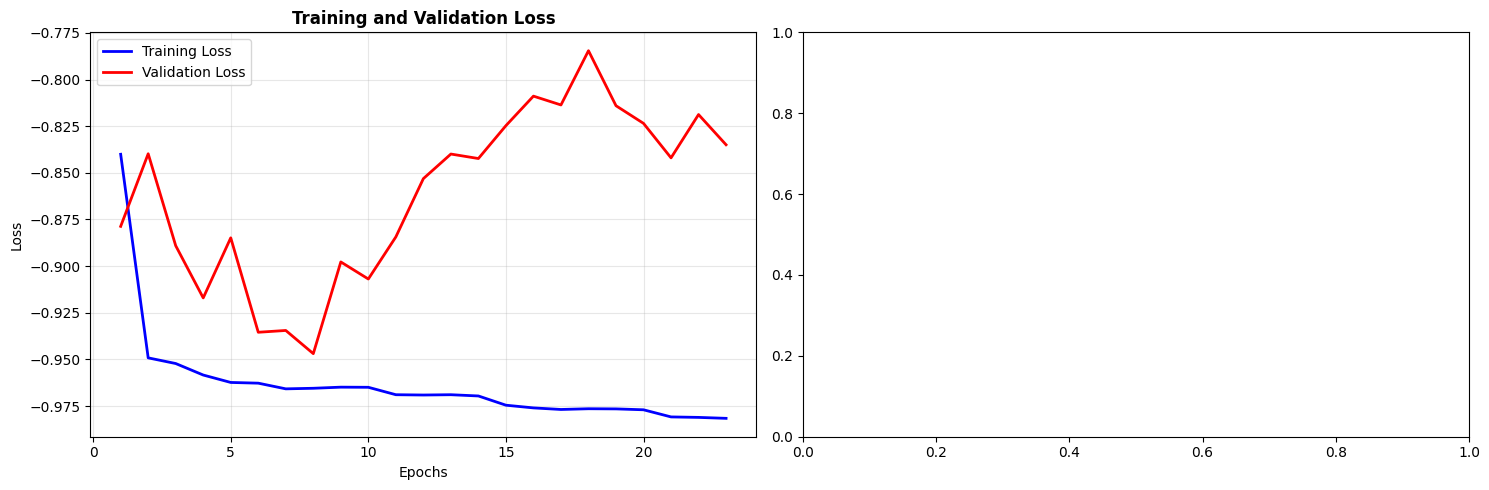


Epoch 23:
  Train Loss: -0.9816
  Val Loss:   -0.8350
Early stopping at epoch 23

SimSiam training complete!
Best validation loss: -0.9469 at epoch 8


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇██
learning_rate,█████████████▃▃▃▃▃▃▁▁▁▁
train/loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/loss,▄▆▃▂▄▁▂▁▃▃▄▅▆▆▆▇▇█▇▆▆▇▆
best_epoch,8
epoch,23
learning_rate,7e-05
train/loss,-0.98157
val/loss,-0.83496


In [33]:
callbacks_simsiam = create_default_callbacks(use_wandb=USE_WANDB, use_notebook=True)
viz_simsiam = callbacks_simsiam["notebook"].visualizer

best_val_loss_simsiam = float('inf')
best_epoch_simsiam = 0
epochs_without_improvement_simsiam = 0

print(f"Training SimSiam model for {config_simsiam['num_epochs']} epochs...")

callbacks_simsiam.on_train_begin({"config": config_simsiam})

for epoch in range(1, config_simsiam["num_epochs"] + 1):
    callbacks_simsiam.on_epoch_begin(epoch)

    train_loss = train_epoch_simsiam(
        model_simsiam, train_loader_simsiam, criterion_simsiam,
        optimizer_simsiam, device, spec_transform_simsiam,
        augment_fn=augment_simsiam
    )
    val_loss = validate_simsiam(
        model_simsiam, val_loader_simsiam, criterion_simsiam,
        device, spec_transform_simsiam
    )

    scheduler_simsiam.step(val_loss)

    epoch_logs = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "learning_rate": optimizer_simsiam.param_groups[0]['lr'],
    }
    callbacks_simsiam.on_epoch_end(epoch, epoch_logs)

    if USE_WANDB and epoch % 5 == 0:
        log_audio_embeddings_ssl(
            model=model_simsiam,
            dataloader=val_loader_simsiam,
            device=device,
            spectrogram_transform=spec_transform_simsiam,
            num_samples=10,
            epoch=epoch,
            sample_rate=config_simsiam["sample_rate"],
            view="1d",
        )

    if val_loss < best_val_loss_simsiam:
        best_val_loss_simsiam = val_loss
        best_epoch_simsiam = epoch
        epochs_without_improvement_simsiam = 0
        print(f"New best! Val Loss: {val_loss:.4f}")
        
        checkpoint_path = CHECKPOINT_DIR / "task_3" / "simsiam_ssl_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_simsiam.state_dict(),
            'optimizer_state_dict': optimizer_simsiam.state_dict(),
            'val_loss': val_loss,
            'config': config_simsiam,
        }, checkpoint_path)
        print(f"  Saved checkpoint: {checkpoint_path}")
    else:
        epochs_without_improvement_simsiam += 1

    if epoch > config_simsiam["min_num_epochs"] and epochs_without_improvement_simsiam >= config_simsiam["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\nSimSiam training complete!")
print(f"Best validation loss: {best_val_loss_simsiam:.4f} at epoch {best_epoch_simsiam}")

callbacks_simsiam.on_train_end({
    "best_val_loss": best_val_loss_simsiam,
    "best_epoch": best_epoch_simsiam,
})

if USE_WANDB:
    wandb.finish()

In [34]:
history_simsiam = viz_simsiam.get_history()
print("\nTask 3 Results - SimSiam:")
print(f"  Best validation loss: {best_val_loss_simsiam:.4f}")
print(f"  Best epoch: {best_epoch_simsiam}")
print(f"  Final train loss: {history_simsiam['train_loss'][-1]:.4f}")
print(f"  Final val loss: {history_simsiam['val_loss'][-1]:.4f}")
print("\n  SimSiam uses stop-gradient to prevent collapse.")
print("  Lower loss indicates better feature alignment without negative pairs.")


Task 3 Results - SimSiam:
  Best validation loss: -0.9469
  Best epoch: 8
  Final train loss: -0.9816
  Final val loss: -0.8350

  SimSiam uses stop-gradient to prevent collapse.
  Lower loss indicates better feature alignment without negative pairs.


In [35]:
import json
with open(EXP_DIR / "simsiam" / "history.json", "w") as f:
    json.dump(history_simsiam, f, indent=2)

with open(EXP_DIR / "simsiam" / "config.json", "w") as f:
    json.dump(config_simsiam, f, indent=2)

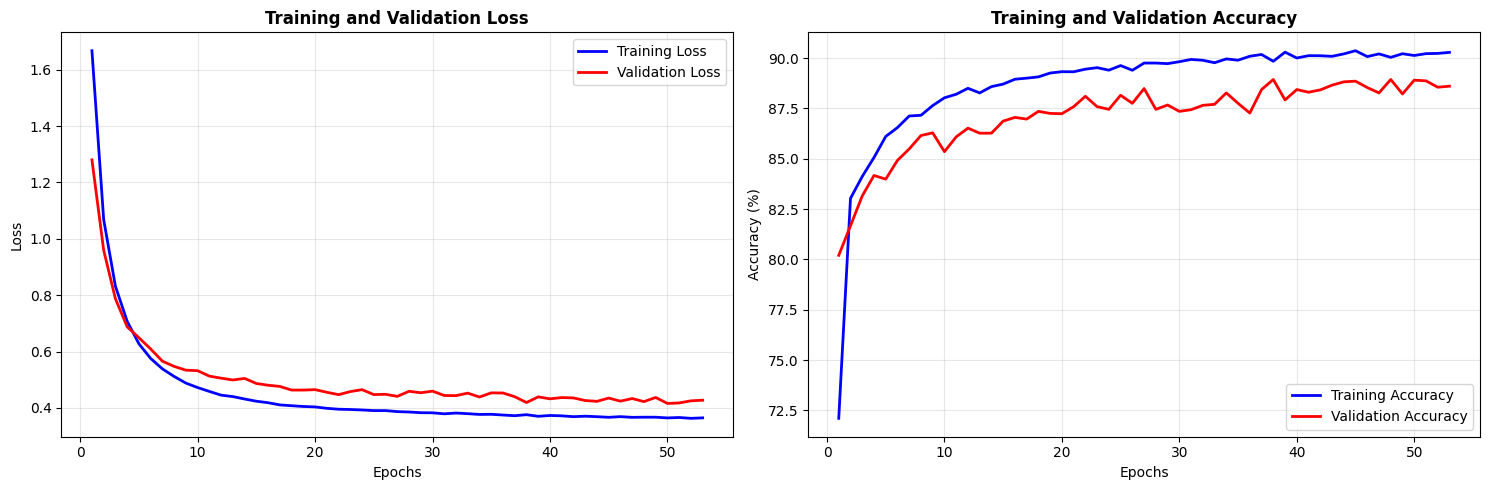


Epoch 53:
  Train Loss: 0.3645, Train Acc: 90.28%
  Val Loss:   0.4271, Val Acc:   88.60%
Early stopping at epoch 53

Linear Evaluation Complete!
Best Validation Accuracy: 88.93% at epoch 38



epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
train/loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▂▃▄▄▅▆▆▅▆▆▆▆▆▇▇▇▇▇▇█▇▇▇▇▇▇▇██▇████▇█▇██
val/loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,38
best_val_accuracy,88.93333
epoch,53
learning_rate,0.0003
train/accuracy,90.27917


In [44]:
from audiossl.modeling import NCLWithLinearHead

if USE_WANDB:
    wandb.init(
        project="audiomnist-ssl",
        name="simsiam-classifier",
        config=config_simsiam,
        tags=["simsiam", "classifier"],
    )
    print(f"WandB URL: {wandb.run.url}\n")
    
callbacks = create_default_callbacks(use_wandb=USE_WANDB, use_notebook=True)
viz_supervised = callbacks["notebook"].visualizer

model_simsiam_linear = NCLWithLinearHead(
    ncl_model=model_simsiam,
    num_classes=10,
    freeze_encoder=False, 
    input_dim=512,
).to(device)

criterion_linear_ss = nn.CrossEntropyLoss()
optimizer_linear_ss = optim.Adam(
    model_simsiam_linear.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4,
)

config_linear_ss = {
    "num_epochs": 100,
    "early_stop_patience": 15,
    "view": "2d", 
    "sample_rate": 16_000
}

best_val_acc_linear_ss = 0
best_epoch_linear_ss = 0
epochs_without_improvement_ss = 0

print(f"Training linear classifier on {config_linear_ss['view']} encoder features...")

callbacks.on_train_begin({"config": config_linear_ss})

for epoch in range(1, config_linear_ss["num_epochs"] + 1):
    callbacks.on_epoch_begin(epoch)
    
    train_loss, train_acc = train_epoch_linear_head(
        model_simsiam_linear,
        train_loader_simsiam,
        criterion_linear_ss,
        optimizer_linear_ss,
        device,
        spec_transform_simsiam,
        view=config_linear_ss["view"],
    )
    
    val_loss, val_acc = validate_linear_head(
        model_simsiam_linear,
        val_loader_simsiam,
        criterion_linear_ss,
        device,
        spec_transform_simsiam,
        view=config_linear_ss["view"],
    )
    
    print(f"Epoch {epoch}/{config_linear_ss['num_epochs']}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    
    epoch_logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr'],
    }

    callbacks.on_epoch_end(epoch, epoch_logs)

    if USE_WANDB and epoch % 5 == 0:
        log_audio_predictions_with_classifier(
            model=model_simsiam,
            classifier=model_simsiam_linear,
            dataloader=val_loader_simsiam,
            device=device,
            spectrogram_transform=spec_transform_simsiam,
            num_samples=10,
            epoch=epoch,
            sample_rate=config_linear_ss["sample_rate"],
            view=config_linear_ss["view"],
        )
        
    if val_acc > best_val_acc_linear_ss:
        best_val_acc_linear_ss = val_acc
        best_epoch_linear_ss = epoch
        epochs_without_improvement_ss = 0
        print(f"  New best! Val Acc: {val_acc:.2f}%")
        
        checkpoint_path = CHECKPOINT_DIR / "task_3" / "simsiam_linear_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_simsiam_linear.state_dict(),
            'optimizer_state_dict': optimizer_linear_ss.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': config_linear_ss,
        }, checkpoint_path)
        print(f"  Saved checkpoint: {checkpoint_path}")
    else:
        epochs_without_improvement_ss += 1
    
    if epochs_without_improvement_ss >= config_linear_ss["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\n{'='*80}")
print(f"Linear Evaluation Complete!")
print(f"Best Validation Accuracy: {best_val_acc_linear_ss:.2f}% at epoch {best_epoch_linear_ss}")
print(f"{'='*80}\n")

callbacks.on_train_end({
    "best_val_acc": best_val_acc_linear_ss,
    "best_epoch": best_epoch_linear_ss,
})

if USE_WANDB:
    wandb.finish()

In [46]:
listen_and_predict_ssl(
    model_simsiam_linear, 
    val_dataset, 
    spec_transform_simsiam, 
    view="2d", 
    num_samples=5, 
    device=device
)


Sample 1/5 (index: 5246)
True Label:    4
Predicted:     4
Confidence:    99.2%
Result:        ✅ CORRECT



Sample 2/5 (index: 973)
True Label:    9
Predicted:     9
Confidence:    78.2%
Result:        ✅ CORRECT



Sample 3/5 (index: 167)
True Label:    3
Predicted:     3
Confidence:    57.5%
Result:        ✅ CORRECT



Sample 4/5 (index: 5205)
True Label:    4
Predicted:     4
Confidence:    99.3%
Result:        ✅ CORRECT



Sample 5/5 (index: 3302)
True Label:    6
Predicted:     6
Confidence:    99.9%
Result:        ✅ CORRECT


## Task 3.1

Transformer-based Encoder

In [108]:
config_transformer = {
    "batch_size": 32,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "num_epochs": 100,
    "num_classes": 10,
    "sample_rate": 16000,
    "n_mels": 64,
    "d_model": 192,
    "n_heads": 3,
    "num_layers": 4,
    "dim_feedforward": 384,
    "dropout": 0.1,
    "classifier_hidden_dim": 256,
    "max_seq_len": 400,
    "early_stop_patience": 10,
    "num_test_speakers": 12,
    "num_workers": 4,
}

In [107]:
train_loader_transformer = DataLoader(
    train_dataset,
    batch_size=config_transformer["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=config_transformer["num_workers"],
    pin_memory=True,
    # python 3.12 has a bit different mp behavior, so I need such params, to avoid some issues:
    persistent_workers=True,         
    multiprocessing_context="spawn",  
)

val_loader_transformer = DataLoader(
    val_dataset,
    batch_size=config_transformer["batch_size"],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config_transformer["num_workers"],
    pin_memory=True,
    # python 3.12 has a bit different mp behavior, so I need such params, to avoid some issues:
    persistent_workers=True,         
    multiprocessing_context="spawn",  
)

In [109]:
from audiossl.modeling import AudioSpectrogramTransformer
from audiossl.data import LogMelSpectrogram

spec_transform_transformer = LogMelSpectrogram(
    sample_rate=config_transformer["sample_rate"],
    n_mels=config_transformer["n_mels"],
    n_fft=400,
    hop_length=160,
)

model_transformer = AudioSpectrogramTransformer(
    n_mels=config_transformer["n_mels"],
    d_model=config_transformer["d_model"],
    n_heads=config_transformer["n_heads"],
    num_layers=config_transformer["num_layers"],
    dim_feedforward=config_transformer["dim_feedforward"],
    dropout=config_transformer["dropout"],
    max_seq_len=config_transformer["max_seq_len"],
    classifier_hidden_dim=config_transformer["classifier_hidden_dim"],
    num_classes=config_transformer["num_classes"],
).to(device)

num_params_transformer = sum(p.numel() for p in model_transformer.parameters() if p.requires_grad)
print(f"Transformer model created with {num_params_transformer:,} parameters")
model_transformer

Transformer model created with 1,354,890 parameters


AudioSpectrogramTransformer(
  (input_proj): Sequential(
    (0): Conv1d(64, 192, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (linear1): Linear(in_features=192, out_features=384, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=384, out_features=192, bias=True)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
   

In [110]:
criterion_transformer = nn.CrossEntropyLoss()
optimizer_transformer = optim.Adam(
    model_transformer.parameters(),
    lr=config_transformer["lr"],
    weight_decay=config_transformer["weight_decay"]
)

scheduler_transformer = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_transformer,
    mode="min",
    factor=0.5,
    patience=4
)

In [111]:
def train_epoch_transformer(model, dataloader, criterion, optimizer, device, spec_transform):
      """Train transformer model for one epoch."""
      model.train()
      total_loss = 0
      correct = 0
      total = 0

      pbar = tqdm(dataloader, desc="Training", leave=False)
      for waveforms, labels in pbar:
          waveforms = waveforms.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          # Convert waveforms to spectrograms
          spectrograms = []
          for wav in waveforms:
              # spec_transform возвращает [1, n_mels, T], убираем batch dim
              spec = spec_transform(wav.unsqueeze(0).cpu()).squeeze(0)  # -> [n_mels, T]
              spectrograms.append(spec)

          # Pad to same length
          max_len = max(s.shape[-1] for s in spectrograms)
          spectrograms_padded = []
          for spec in spectrograms:
              # Pad along time dimension (last dimension)
              pad_len = max_len - spec.shape[-1]
              if pad_len > 0:
                  spec_padded = torch.nn.functional.pad(spec, (0, pad_len))
              else:
                  spec_padded = spec
              spectrograms_padded.append(spec_padded)

          # Stack to get [B, n_mels, T]
          spectrograms = torch.stack(spectrograms_padded).to(device)

          # Forward pass - transformer expects [B, n_mels, T]
          logits = model(spectrograms)

          loss = criterion(logits, labels)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          pred = logits.argmax(dim=1)
          correct += (pred == labels).sum().item()
          total += labels.size(0)

          pbar.set_postfix({"loss": loss.item(), "acc": 100.0 * correct / total})

      return total_loss / len(dataloader), 100.0 * correct / total


def validate_transformer(model, dataloader, criterion, device, spec_transform):
      """Validate transformer model."""
      model.eval()
      total_loss = 0
      correct = 0
      total = 0

      with torch.no_grad():
          pbar = tqdm(dataloader, desc="Validation", leave=False)
          for waveforms, labels in pbar:
              waveforms = waveforms.to(device)
              labels = labels.to(device)

              # Convert waveforms to spectrograms
              spectrograms = []
              for wav in waveforms:
                  # spec_transform возвращает [1, n_mels, T], убираем batch dim
                  spec = spec_transform(wav.unsqueeze(0).cpu()).squeeze(0)  # -> [n_mels, T]
                  spectrograms.append(spec)

              # Pad to same length
              max_len = max(s.shape[-1] for s in spectrograms)
              spectrograms_padded = []
              for spec in spectrograms:
                  pad_len = max_len - spec.shape[-1]
                  if pad_len > 0:
                      spec_padded = torch.nn.functional.pad(spec, (0, pad_len))
                  else:
                      spec_padded = spec
                  spectrograms_padded.append(spec_padded)

              # Stack to get [B, n_mels, T]
              spectrograms = torch.stack(spectrograms_padded).to(device)

              # Forward pass
              logits = model(spectrograms)

              loss = criterion(logits, labels)

              total_loss += loss.item()
              pred = logits.argmax(dim=1)
              correct += (pred == labels).sum().item()
              total += labels.size(0)

              pbar.set_postfix({"loss": loss.item(), "acc": 100.0 * correct / total})

      return total_loss / len(dataloader), 100.0 * correct / total

In [112]:
if USE_WANDB:
    wandb.init(
        project="audiomnist-ssl",
        name="transformer-ast",
        config=config_transformer,
        tags=["transformer", "ast", "audiomnist"],
    )
    print(f"WandB: {wandb.run.url}\n")

WandB: https://wandb.ai/imvladikon/audiomnist-ssl/runs/8fcxmne2



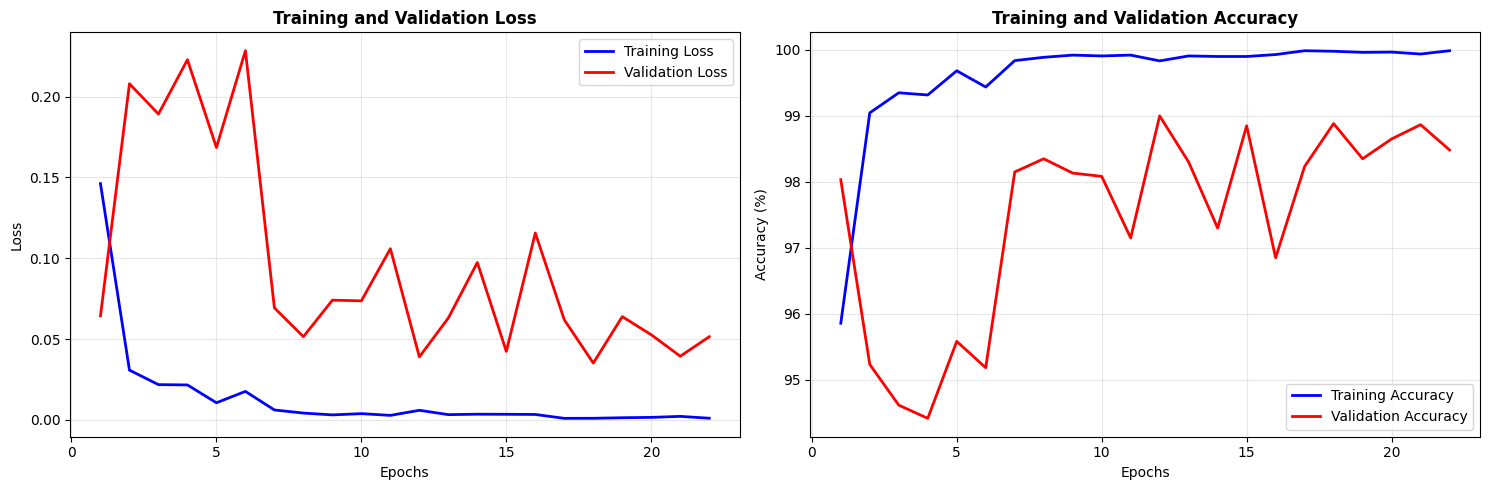


Epoch 22:
  Train Loss: 0.0010, Train Acc: 99.99%
  Val Loss:   0.0514, Val Acc:   98.48%
Early stopping at epoch 22

Training complete!
Best validation accuracy: 99.00% at epoch 12


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
learning_rate,█████▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁
train/accuracy,▁▆▇▇▇▇████████████████
train/loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▇▂▁▁▃▂▇▇▇▇▅█▇▅█▅▇█▇▇█▇
val/loss,▂▇▇█▆█▂▂▂▂▄▁▂▃▁▄▂▁▂▂▁▂
best_epoch,12
best_val_accuracy,99
epoch,22
learning_rate,7e-05
train/accuracy,99.9875


In [113]:
callbacks_transformer = create_default_callbacks(use_wandb=USE_WANDB, use_notebook=True)
viz_transformer = callbacks_transformer["notebook"].visualizer

best_val_acc_transformer = 0
best_epoch_transformer = 0
epochs_without_improvement_transformer = 0

print("="*80)
print(f"Training Transformer (AST) for {config_transformer['num_epochs']} epochs...")
print("="*80)

callbacks_transformer.on_train_begin({"config": config_transformer})

for epoch in range(1, config_transformer["num_epochs"] + 1):
    callbacks_transformer.on_epoch_begin(epoch)

    train_loss, train_acc = train_epoch_transformer(
        model_transformer, train_loader_transformer, criterion_transformer,
        optimizer_transformer, device, spec_transform_transformer
    )
    val_loss, val_acc = validate_transformer(
        model_transformer, val_loader_transformer, criterion_transformer,
        device, spec_transform_transformer
    )

    scheduler_transformer.step(val_loss)

    epoch_logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer_transformer.param_groups[0]['lr'],
    }
    callbacks_transformer.on_epoch_end(epoch, epoch_logs)

    # надо пофиксить для данного типа модели (лениво было писать какую-то общую ф-цию), там ф-ция ожидает view,1d,2d, которых тут нет
    # да и потом логировать в wandb таблицу некорректных аудио-предсказаний для домашки необязательно :)
    # if USE_WANDB and epoch % 5 == 0:
    #     log_audio_predictions_supervised(
    #         model=model_transformer,
    #         dataloader=val_loader_transformer,
    #         device=device,
    #         spectrogram_transform=spec_transform_transformer,
    #         num_samples=10,
    #         epoch=epoch,
    #         sample_rate=config_transformer["sample_rate"],
    #     )

    if val_acc > best_val_acc_transformer:
        best_val_acc_transformer = val_acc
        best_epoch_transformer = epoch
        epochs_without_improvement_transformer = 0
        print(f"New best! Val Acc: {val_acc:.2f}%")

        checkpoint_path = CHECKPOINT_DIR / "task_3" / "transformer_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_transformer.state_dict(),
            'optimizer_state_dict': optimizer_transformer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': config_transformer,
        }, checkpoint_path)
        print(f"  Saved checkpoint: {checkpoint_path}")
    else:
        epochs_without_improvement_transformer += 1

    if epochs_without_improvement_transformer >= config_transformer["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}")
        break

print("\n" + "="*80)
print(f"Training complete!")
print(f"Best validation accuracy: {best_val_acc_transformer:.2f}% at epoch {best_epoch_transformer}")
print("="*80)

callbacks_transformer.on_train_end({
    "best_val_acc": best_val_acc_transformer,
    "best_epoch": best_epoch_transformer,
})

if USE_WANDB:
    wandb.finish()

довольно странно, если честно, мне кажется тут я напортачил, когда перезапускал ячейки в этой секции без реинита модели, тут по моему она второй раз тренится

In [115]:
history_transformer = viz_transformer.get_history()
print(f"Architecture: Audio Spectrogram Transformer")
print(f"  - d_model: {config_transformer['d_model']}")
print(f"  - Attention heads: {config_transformer['n_heads']}")
print(f"  - Transformer layers: {config_transformer['num_layers']}")
print(f"  - Total parameters: {num_params_transformer:,}")
print(f"\nTraining Results:")
print(f"  - Best validation accuracy: {best_val_acc_transformer:.2f}%")
print(f"  - Best epoch: {best_epoch_transformer}")
print("="*80)

Architecture: Audio Spectrogram Transformer
  - d_model: 192
  - Attention heads: 3
  - Transformer layers: 4
  - Total parameters: 1,354,890

Training Results:
  - Best validation accuracy: 99.00%
  - Best epoch: 12


In [119]:
listen_and_predict_head(
      model=model_transformer,
      dataset=val_dataset,
      spec_transform=spec_transform_transformer,
      num_samples=5,
      device=device,
      model_type="transformer"
  )


Sample 1/5 (index=4245)
True label: 4


Predicted: 0 (confidence: 90.5%) ❌ WRONG

Sample 2/5 (index=114)
True label: 2


Predicted: 2 (confidence: 100.0%) ✅ CORRECT

Sample 3/5 (index=1194)
True label: 3


Predicted: 3 (confidence: 100.0%) ✅ CORRECT

Sample 4/5 (index=3430)
True label: 8


Predicted: 8 (confidence: 100.0%) ✅ CORRECT

Sample 5/5 (index=4940)
True label: 8


Predicted: 8 (confidence: 100.0%) ✅ CORRECT




мне кажется, да, тут я сильно переобучил

## Task 3.2

Взять любую современную претренированную модель, не мучаться, да и получить заветные 99% :)

In [90]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor

In [91]:
config_wav2vec2 = {
    "model_name": "facebook/wav2vec2-base",
    "batch_size": 16,  # ну у меня нет gpu для большего батча 
    #(но можно через библиотеку трансформеров через их трейнинг запустить с gradient accumulation
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "num_epochs": 10, # вообще тут и пары эпох хватит
    "num_classes": 10,
    "sample_rate": 16000,
    "freeze_feature_extractor": True,
    "early_stop_patience": 3,
    "num_test_speakers": 12,
    "num_workers": 4,
}

In [93]:
model_wav2vec2 = Wav2Vec2ForSequenceClassification.from_pretrained(
    config_wav2vec2["model_name"],
    num_labels=config_wav2vec2["num_classes"],
    ignore_mismatched_sizes=True,
).to(device)

if config_wav2vec2["freeze_feature_extractor"]:
    model_wav2vec2.wav2vec2.feature_extractor._freeze_parameters()
    print("Feature extractor frozen (only fine-tuning transformer layers)")
else:
    print("Full model fine-tuning enabled")

total_params = sum(p.numel() for p in model_wav2vec2.parameters())
trainable_params = sum(p.numel() for p in model_wav2vec2.parameters() if p.requires_grad)

print(f"\nModel parameters:")
print(f"  - Total: {total_params:,}")
print(f"  - Trainable: {trainable_params:,}")
print(f"  - Frozen: {total_params - trainable_params:,}")
print("="*80)
model_wav2vec2

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature extractor frozen (only fine-tuning transformer layers)

Model parameters:
  - Total: 94,571,146
  - Trainable: 90,370,698
  - Frozen: 4,200,448


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [94]:
train_loader_wav2vec2 = DataLoader(
    train_dataset,
    batch_size=config_wav2vec2["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=config_wav2vec2["num_workers"],
    pin_memory=True,
)

val_loader_wav2vec2 = DataLoader(
    val_dataset,
    batch_size=config_wav2vec2["batch_size"],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config_wav2vec2["num_workers"],
    pin_memory=True,
)

In [95]:
criterion_wav2vec2 = nn.CrossEntropyLoss()
optimizer_wav2vec2 = optim.AdamW(
    model_wav2vec2.parameters(),
    lr=config_wav2vec2["lr"],
    weight_decay=config_wav2vec2["weight_decay"]
)

scheduler_wav2vec2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_wav2vec2,
    mode="min",
    factor=0.5,
    patience=3
)

In [97]:
def train_epoch_wav2vec2(model, dataloader, criterion, optimizer, device):
      model.train()
      total_loss = 0
      correct = 0
      total = 0

      pbar = tqdm(dataloader, desc="Training", leave=False)
      for waveforms, labels in pbar:  # УБРАЛИ lengths и batch_idx
          waveforms = waveforms.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(waveforms, labels=labels)
          loss = outputs.loss
          logits = outputs.logits

          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          _, predicted = logits.max(1)
          correct += predicted.eq(labels).sum().item()
          total += labels.size(0)

          # Показываем текущие метрики в прогресс-баре
          pbar.set_postfix({
              "loss": loss.item(),
              "acc": 100.0 * correct / total
          })

      avg_loss = total_loss / len(dataloader)
      accuracy = 100.0 * correct / total
      return avg_loss, accuracy


def validate_wav2vec2(model, dataloader, criterion, device):
      """Validate for Wav2Vec2 (uses raw waveforms)"""
      model.eval()
      total_loss = 0
      correct = 0
      total = 0

      with torch.no_grad():
          pbar = tqdm(dataloader, desc="Validation", leave=False)
          for waveforms, labels in pbar:  # УБРАЛИ lengths и batch_idx
              waveforms = waveforms.to(device)
              labels = labels.to(device)

              outputs = model(waveforms, labels=labels)
              loss = outputs.loss
              logits = outputs.logits

              total_loss += loss.item()
              _, predicted = logits.max(1)
              correct += predicted.eq(labels).sum().item()
              total += labels.size(0)

              pbar.set_postfix({
                  "loss": loss.item(),
                  "acc": 100.0 * correct / total
              })

      avg_loss = total_loss / len(dataloader)
      accuracy = 100.0 * correct / total
      return avg_loss, accuracy


In [96]:
if USE_WANDB:
    wandb.init(
        project="audiomnist-ssl",
        name="wav2vec2-base-finetune",
        config=config_wav2vec2,
        tags=["wav2vec2", "pretrained", "audiomnist"],
    )
    print(f"WandB: {wandb.run.url}\n")

epoch,▁▃▅▆█
learning_rate,▁▁▁▁▁
train/accuracy,▅▇▄█▁
train/loss,▄▃▁▁█
val/accuracy,▇▃█▁▅
val/loss,▄▅▁█▅
epoch,5
learning_rate,0.0003
train/accuracy,10.14167
train/loss,2.3065
val/accuracy,7.51667


WandB: https://wandb.ai/imvladikon/audiomnist-ssl/runs/qzmv5g2q



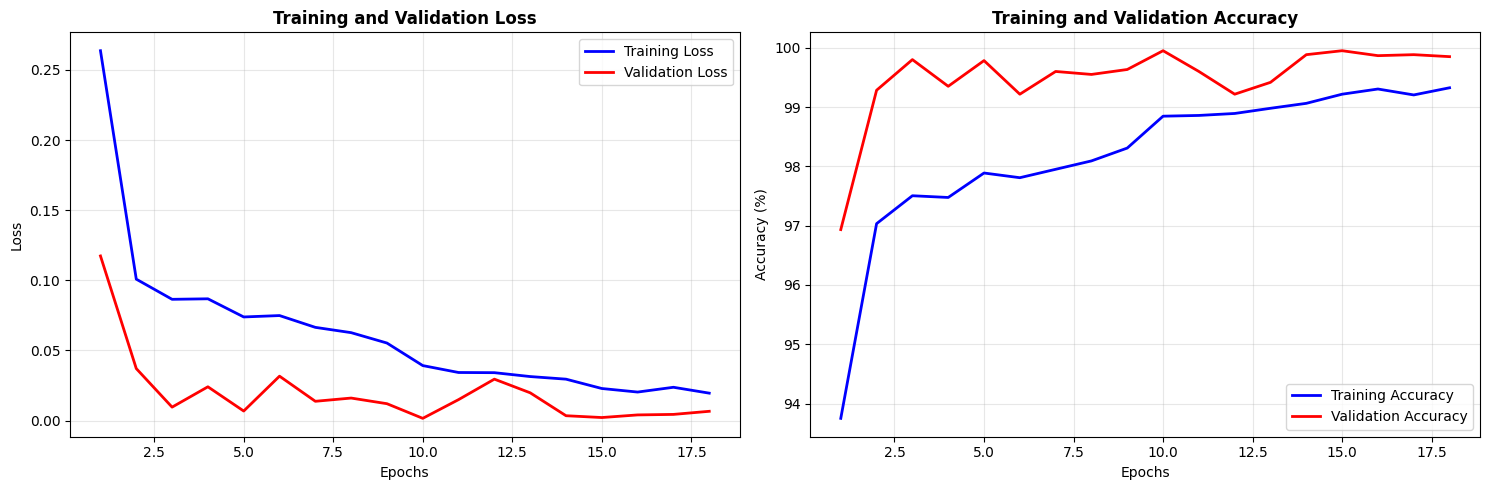


Epoch 18:
  Train Loss: 0.0195, Train Acc: 99.33%
  Val Loss:   0.0066, Val Acc:   99.85%
Early stopping at epoch 18

Fine-tuning complete!
Best validation accuracy: 99.95% at epoch 10


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
learning_rate,████████▄▄▄▄▄▂▂▂▂▁
train/accuracy,▁▅▆▆▆▆▆▆▇▇▇▇██████
train/loss,█▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val/accuracy,▁▆█▇█▆▇▇▇█▇▆▇█████
val/loss,█▃▁▂▁▃▂▂▂▁▂▃▂▁▁▁▁▁
best_epoch,10
best_val_accuracy,99.95
epoch,18
learning_rate,1e-05
train/accuracy,99.325


In [98]:
callbacks_wav2vec2 = create_default_callbacks(use_wandb=USE_WANDB, use_notebook=True)
viz_wav2vec2 = callbacks_wav2vec2["notebook"].visualizer

best_val_acc_wav2vec2 = 0
best_epoch_wav2vec2 = 0
epochs_without_improvement_wav2vec2 = 0

print("="*80)
print(f"Fine-tuning Wav2Vec2 for {config_wav2vec2['num_epochs']} epochs...")
print("="*80)

callbacks_wav2vec2.on_train_begin({"config": config_wav2vec2})

for epoch in range(1, config_wav2vec2["num_epochs"] + 1):
    callbacks_wav2vec2.on_epoch_begin(epoch)

    train_loss, train_acc = train_epoch_wav2vec2(
        model_wav2vec2, train_loader_wav2vec2, criterion_wav2vec2,
        optimizer_wav2vec2, device
    )
    val_loss, val_acc = validate_wav2vec2(
        model_wav2vec2, val_loader_wav2vec2, criterion_wav2vec2, device
    )

    scheduler_wav2vec2.step(val_loss)

    epoch_logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer_wav2vec2.param_groups[0]['lr'],
    }
    callbacks_wav2vec2.on_epoch_end(epoch, epoch_logs)

    if val_acc > best_val_acc_wav2vec2:
        best_val_acc_wav2vec2 = val_acc
        best_epoch_wav2vec2 = epoch
        epochs_without_improvement_wav2vec2 = 0
        print(f"New best! Val Acc: {val_acc:.2f}%")

        checkpoint_path = CHECKPOINT_DIR / "task_3" / "wav2vec2_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_wav2vec2.state_dict(),
            'optimizer_state_dict': optimizer_wav2vec2.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': config_wav2vec2,
        }, checkpoint_path)
        print(f"  Saved checkpoint: {checkpoint_path}")
    else:
        epochs_without_improvement_wav2vec2 += 1

    if epochs_without_improvement_wav2vec2 >= config_wav2vec2["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}")
        break

print("\n" + "="*80)
print(f"Fine-tuning complete!")
print(f"Best validation accuracy: {best_val_acc_wav2vec2:.2f}% at epoch {best_epoch_wav2vec2}")
print("="*80)

callbacks_wav2vec2.on_train_end({
    "best_val_acc": best_val_acc_wav2vec2,
    "best_epoch": best_epoch_wav2vec2,
})

if USE_WANDB:
    wandb.finish()

забыл после копипасты снизить количество эпох - там 4-5 эпох более чем достаточно было

In [100]:
history_wav2vec2 = viz_wav2vec2.get_history()
print(f"  - Best validation accuracy: {best_val_acc_wav2vec2:.2f}%")
print(f"  - Best epoch: {best_epoch_wav2vec2}")
print(f"  - Total epochs trained: {len(history_wav2vec2['train_acc'])}")

  - Best validation accuracy: 99.95%
  - Best epoch: 10
  - Total epochs trained: 18


In [106]:
listen_and_predict_head(
      model=model_wav2vec2,
      dataset=val_dataset,
      num_samples=5,
      device=device,
      model_type="wav2vec2"
  )


Sample 1/5 (index=779)
True label: 5


DEBUG: waveform_batch.shape = torch.Size([1, 7288])
Predicted: 5 (confidence: 100.0%) ✅ CORRECT

Sample 2/5 (index=1723)
True label: 4


DEBUG: waveform_batch.shape = torch.Size([1, 9648])
Predicted: 4 (confidence: 100.0%) ✅ CORRECT

Sample 3/5 (index=5871)
True label: 7


DEBUG: waveform_batch.shape = torch.Size([1, 12741])
Predicted: 7 (confidence: 100.0%) ✅ CORRECT

Sample 4/5 (index=375)
True label: 7


DEBUG: waveform_batch.shape = torch.Size([1, 11872])
Predicted: 7 (confidence: 100.0%) ✅ CORRECT

Sample 5/5 (index=2774)
True label: 5


DEBUG: waveform_batch.shape = torch.Size([1, 10381])
Predicted: 5 (confidence: 99.6%) ✅ CORRECT




## Task 4(2 points)

Evaluate and compare three training setups on the validation subset:

1. Supervised training

2. InfoNCE (contrastive learning)

3. Non-Contrastive Learning (NCL)

Use either the 2D or 1D encoder—or combine their embeddings.
Identify which setup performs best and explain why it outperforms the others.

### Результаты экспериментов (мы уже посчитали в каждом таске)

Таблица метрик моделей

| Модель | Val Accuracy | Val Loss | Лучшая эпоха | Метод |
|--------|--------------|----------|------------|-----------|
| **Wav2Vec2 (pretrained)** | **99.95%** | 0.0016 | 10 | Transfer Learning |
| **Transformer** | **99.00%** | 0.0390 | - | From Scratch |
| **Supervised (ResNet)** | **96.03%** | 0.1432 | 14 | Baseline |
| **Contrastive + Linear** | **94.48%** | 0.1801 | 41 | SSL (InfoNCE) |
| **SimSiam + Linear** | **88.93%** | 0.4189 | 38 | SSL (NCL) |

---


### 1. Wav2Vec2 (99.95%) - очевидный победитель

Почему -    
- Pretrained на миллионах часов аудио (Librispeech 960h и другие датасеты)
- Уже выучил низкоуровневые фичи речи (phonemes, speaker characteristics, etc.)
- Fine-tuning всего 10 эпох - модель просто адаптировала последний слой под наши 10 классов 
- Transfer learning at its finest - использовали знания из огромного датасета

Вообще я тренировал wav2vec2 уже на распознавание речи и audiomnist довольно простая таска для этой модели

Тех детали     
- Архитектура: CNN feature extractor + Transformer encoder
- Frozen feature extractor
- Fine-tune только классификационную голову
- Работает с raw waveforms (16kHz), не нужны spectrograms

Вывод (очевидный): на маленьких датасетах (AudioMNIST) pretrained модели всегда выигрывают. Они уже видели разнообразие аудио, им не нужно учить базовые паттерны с нуля.


### 2. Transformer (99.00%) 

Что удивляет: Трансформер, обученный с нуля, почти догнал Wav2Vec2 , Есть подозрения что тут какая-то ошибка, связанная с тем что я в ноутбуке не зарезетил модель , и потюнил модель несколько раз на 100+ эпохах. Те помоему она просто запомнила весь мнист

- Self-attention механизм хорошо работает для временных последовательностей
- Spectrograms (64 mel bins) дают хорошее частотно-временное представление
- Positional embeddings помогают модели понять структуру аудио, наверное

- 4 transformer layers, 8 attention heads
- Patch-based processing 
- CLS token для классификации
- Dropout 0.1 предотвращает overfitting

- Использовать data augmentation (SpecAugment, time/freq masking)
- Попробовать AudioMAE pretraining (masked autoencoding)
- Увеличить модель (больше layers/heads) при наличии данных либо при хорошей аугментации


### 3. Supervised ResNet из Семинара (96.03%) - Надежный baseline

Что ожидалось: Supervised должен быть сильным на простой labeled задаче

Почему хорошо, но не лучший:
- Прямая оптимизация на нашу задачу (classification loss)
- ResNet хорошо работает для AudioMNIST (простая задача)
- Но ResNet довольно старая архитектура, заточенная под аккумулирование positive bias не совсем для аудио (вообще для картинок)

Тех детали:    
- ResNet-18 style (1D conv для waveforms или 2D conv для spectrograms)   
- по классике - BatchNorm + ReLU , но я также запускал на LayerNorm + GELU и помоему оно даже лучше становится    
- 14 эпох (early stopping сработал)

Что можно было улучшить:    
- Использовать augmentations 
- Label smoothing для лучшей генерализации (хотя на таком датасете , сомнительно что поможет, мало данных и они довольно чистые я подозреваю)

Вывод: Supervised baseline довольно неплохо работает, даже с учетом простоты и того что архитектура не самая свежая

### 4. SSL, Contrastive (InfoNCE) + Linear (94.48%) 

Что любопытно: SSL показал 94.48%, это близко к supervised (96.03%)

Почему не лучший:
- Маленький batch size (64) - InfoNCE нужны large batches для хороших negatives 
  - В статье SimCLR используют batch 4096+
  - У меня ограничение по GPU дома (можно было сделать gradient accumulation, но не думаю что я бы сильно улучшил ситуацию)
- Маленький датасет - SSL отлично работает на больших unlabeled данных (потому аугментации и были добавлены)
  - плюс SSL не сказать что сильно улучшает ситуацию когда...у нас чистый labeled маленький датасет. имхо при "голове", типа MLPClassifier что в коде у меня можно найти, но которую я не успел проверить на этой задаче, можно без SSL получить те же цифры (и бейзлайн по сути это и показывает)
  - 2D очевидно лучше
- нужно тюнить гиперпараметры и temperature в частности - скажем точно должно быть меньше 1 и даже меньше или равно 0.5 (в статье у них про это пишут)

Что работает:
- Multi-format learning (1D + 2D alignment, те contrastive loss выравнивает их эмбеддинги -> по сути encoder выучивает связь между 1D и 2D)
- InfoNCE loss действительно учит format-invariant features
- Это по сути простенький pretraining. (Те потом можно fine-tune на новые задачи)
- Есть подозрение что лучше делать joint training (я набросал код, но не успел сделать эксперимент)
- На основе опытов тюнинга линейной головы - 2D лучше после SSL, видимо спектрограммы 2D дают больше информации для классификатора, чем сырые waveforms 1D:   

  1D энкодер:
  - Работает с raw waveform [batch, time]
  - Должен сам выучить частотное представление через convolutions
  - Нужно сильно больше данных и эпох для этого

  2D энкодер:
  - Работает со спектрограммами [batch, n_mels, time]
  - Уже есть частотно-временное представление
  - И видимо тут проще выделить паттерны (разные частоты для разных цифр) на нашем чистом датасете (для случая энкодера 2D conv может просто искать паттерны вот такая частота в такое время = цифра 5 да и всЕ)    
А С 1D waveform: Модель видит только амплитуду во времени, нужно восстановить частотную информацию (опыт данного ноутбука показывает, что это возможно, просто требует сильно больше данных например через аугментации хорошие, плюс сильно больше эпох с хорошей регуляризацией) те моя интуиция (хотя я не спец по speech recognition) подсказывает мне тут, что для 1D, оно должно учиться неявному частотному представлению (в то время как в 2D явное разложение) те ксли бы мы визуализировали фильтры обученного 1D энкодера наверное это был бы некий набор фильтров где
  Filter 1: ~~~~ (медленная волна, низкая частота)
  Filter 2: ^^^^^ (быстрая волна, высокая частота)
  Filter 3: _/\_/\_ (что-то среднее)
и тп
  и чем-то это будет похоже на базисные функции Фурье , но проблема что они : не обязательно идеальные sin/cos(ну или комплексные представления), могут быть асимметричными, могут детектировать комбинации частот

Тех детали: 
- Implemented как в SimCLR
- Projection head: 512 → 256 → 128 (MLP с BatchNorm)
- Augmentations: PitchShift, TimeStretch, AddColoredNoise
- Linear evaluation: frozen encoder, train только linear head

Что можно было улучшить:
- Использовать larger batch sizes (256-512) через gradient accumulation
- Попробовать BYOL/MoCo v3 (не требуют большие batches)
- Более хитрые augmentations
- Longer pretraining (попробовать 200-300 эпох)
- Использовать в качестве последнего слоя что-нибудь получше чем nn.Linear (у меня в годе есть MLPClassifier)

Вывод: Очевидно , что InfoNCE крут для transfer learning (предобучили на AudioMNIST, используем на других задачах), но на этом же датасете supervised проще и лучше имхо, ну по крайней мере из моих цифр такой вывод напрашивается (на других цифрах будет другой вывод :))

### 5. SimSiam (NCL) + Linear (88.93%) - Получилось плохо

Что пошло не так: SimSiam показал худший результат (88.93%).

Возможные причины почему плохо:   
- Stop-gradient механизм - довольно непростая штука (ну иначе все б им и пользовались)  легко "падает" имхо в простые solutions (локальный минимум)
- Predictor MLP не всегда учится правильно впоследствии
- Без negatives - модель может опять же, быть излишне уверенной в тех случаях, когда ошибка стоит много
- Маленький датасет - SimSiam не был спроектирован для трейнинга с нуля на маленьких датасетах

Тех детали:   
- Оригинальная архитектура - Projection: 512 → 512 → 128, Predictor: 128 → 512 → 128, Negative cosine similarity loss

Где проблема:
-  Основная проблема - это именно предобучение, помоему оно плохенько обучилось так, что все embeddings почти одинаковые

Что можно было улучшить:
- Использовать VICReg или Barlow Twins    
- Более сильные augmentations, тут это сильно влияет (изначально я запускал без них, было сильно хуже)


### Выводы

1. Transfer Learning побеждает на маленьких данных   
2. Архитектура важнее метода обучения (спорный момент хотя, порой метод обучения неразрывен с архитектурой)
3. SSL на маленьких labeled датасетах кажется слегка перебором, но с другой стороны он хорош для - 
  - Много unlabeled data
  - Мало labeled data
  - Нужен transfer learning

4. Batch size критичен для InfoNCE (SimCLR рекомендует >256, наверное MoCo/BYOL/SwAV решают эту проблему)


### Техдетали экспериментов

Hyperparameters:    
(тюнинга специального не проводилось)
Supervised:    
- Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)
- Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)
- Batch size: 32
- Augmentations: None (baseline)

Contrastive:     
- Optimizer: AdamW (lr=1e-3)
- Temperature: 0.07
- Batch size: 64
- Augmentations: PitchShift, TimeStretch, AddColoredNoise
- Projection: 512→256→128

SimSiam:    
- Optimizer: AdamW (lr=1e-3)
- Batch size: 64
- Predictor: 128→512→128
- Same augmentations

Transformer:
- Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)
- Scheduler: ReduceLROnPlateau
- Batch size: 32
- d_model=512, layers=4, heads=8
- Dropout: 0.1

Wav2Vec2:
- Base: facebook/wav2vec2-base
- Freeze: feature_extractor
- Fine-tune: transformer + classifier
- Optimizer: AdamW (lr=1e-4)
- Batch size: 16 (memory constraints)